In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import os.path

index_list = [
    "loadtest-webrtc-preliminary-mediasoup-2p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-2p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-5p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-5p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-6p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-6p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-7p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-7p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-8p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-8p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-10p-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-10p-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-3p-10s-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-3p-10s-c5xlarge-final",
    "loadtest-webrtc-preliminary-mediasoup-3p-40s-t3medium-final", "loadtest-webrtc-preliminary-mediasoup-3p-40s-c5xlarge-final"
]

node_types = ["browseremulator", "masternode", "medianode"]

seconds_per_fragment = 17


In [23]:
df_list = [pd.read_csv(f"dfs/{x}.csv")
           for x in index_list if os.path.isfile(f"dfs/{x}.csv")]
for df_user in df_list:
    df_user["@timestamp"] = pd.to_datetime(df_user["@timestamp"])
    df_user["cut_index"] = df_user["cut_index"] * seconds_per_fragment


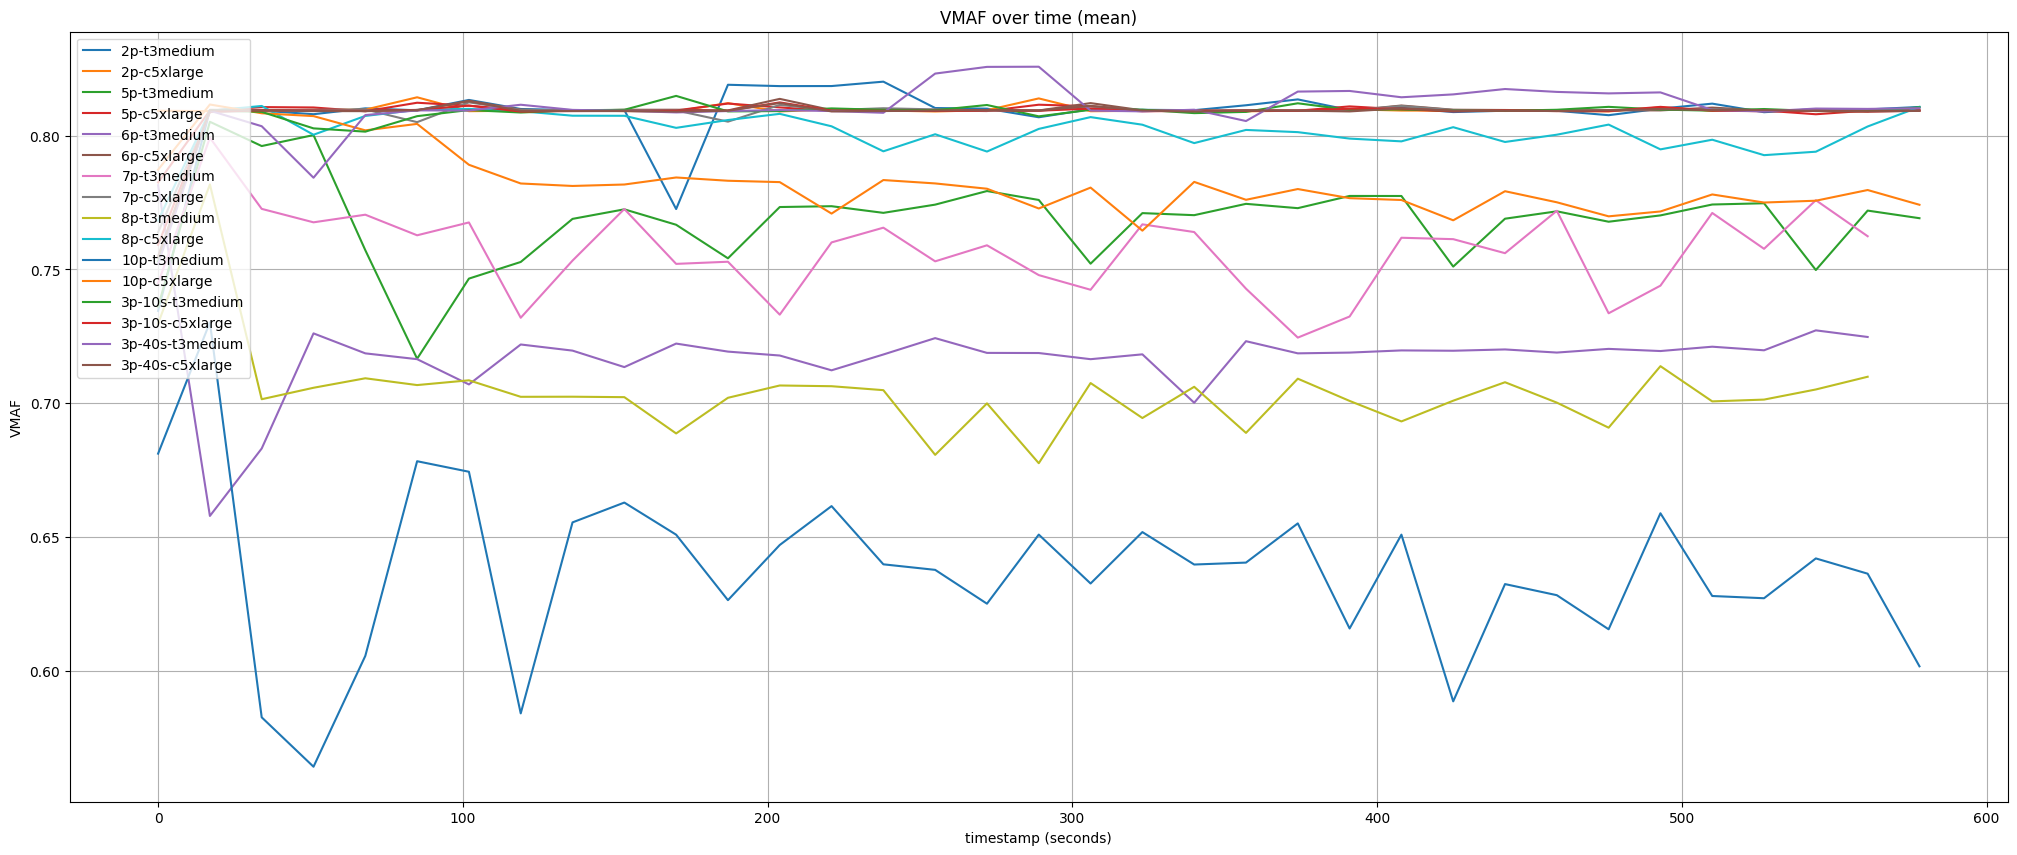

In [24]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
    plot_name = index_list[i][38:-6]
    if not df_mean.empty:
        plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean)")
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.grid()
# plt.ylim(0, 1)
plt.legend(loc="upper left")


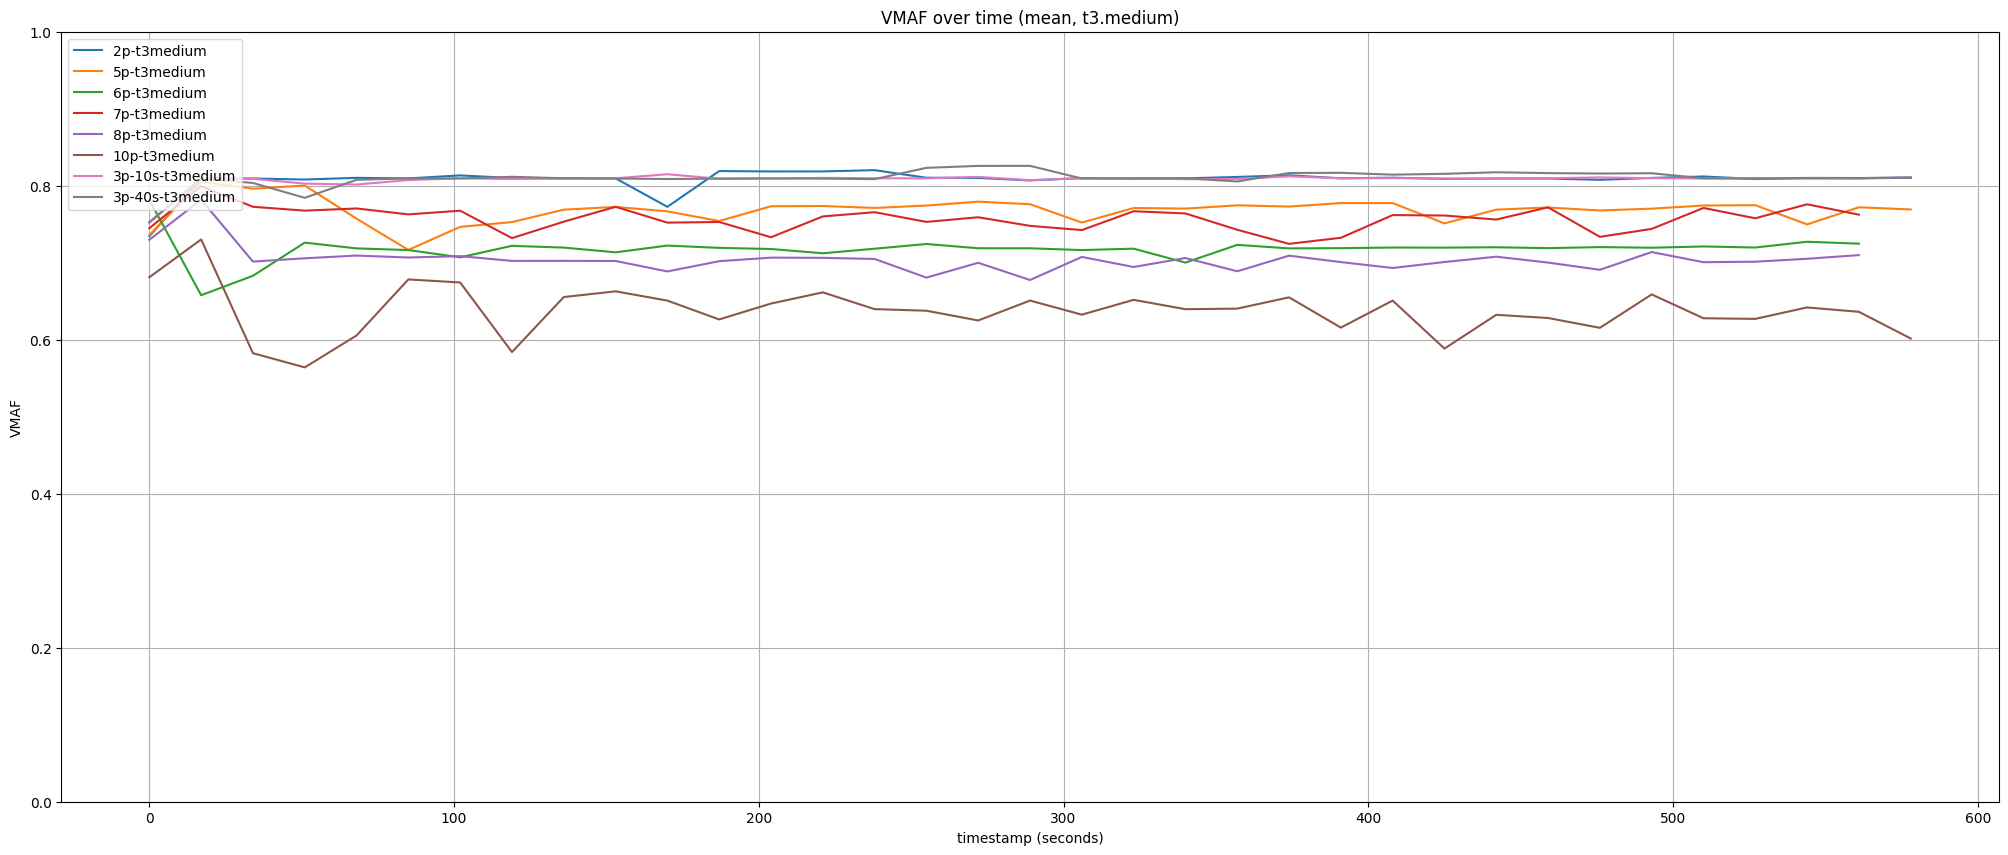

In [25]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    if (i % 2 == 0):
        df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
        plot_name = index_list[i][38:-6]
        if not df_mean.empty:
            plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean, t3.medium)")
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.grid()
plt.ylim(0, 1)
plt.legend(loc="upper left")


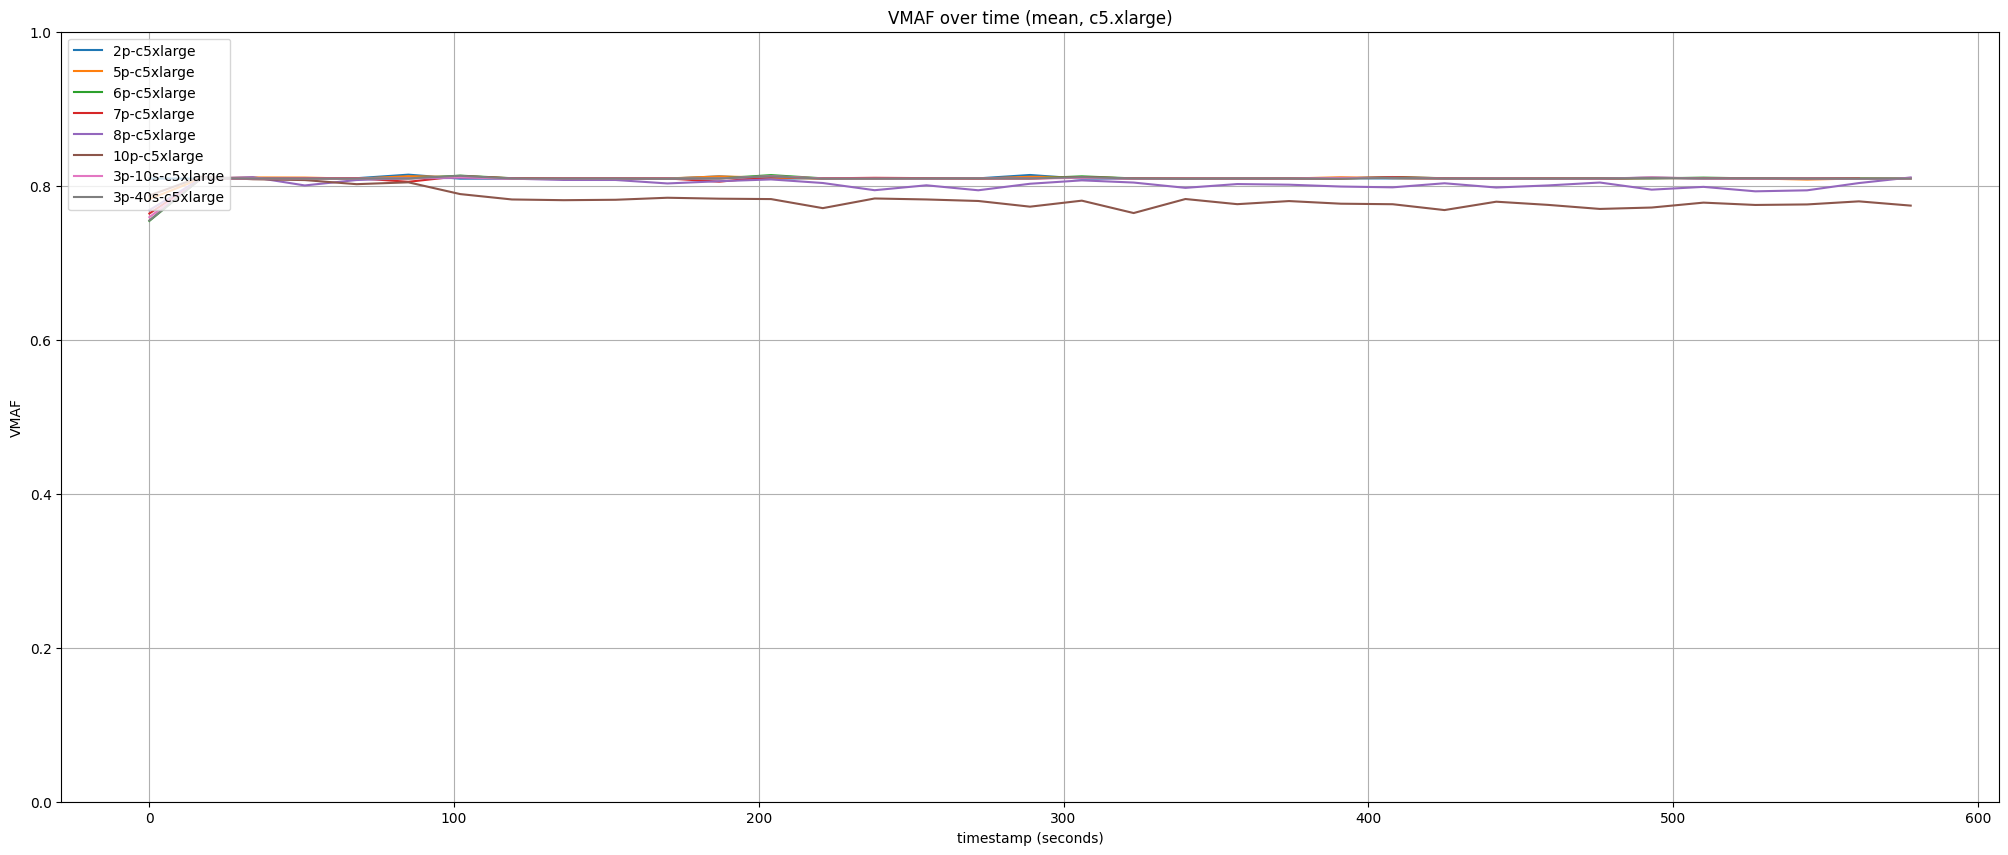

In [26]:
plt.rcParams['figure.figsize'] = [25, 10]


for i, df_tmp in enumerate(df_list):
    if (i % 2 != 0):
        df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
        plot_name = index_list[i][38:-6]
        if not df_mean.empty:
            plt.plot(df_mean.index, df_mean["vmaf"], label=plot_name)

plt.title("VMAF over time (mean, c5.xlarge)")
plt.xlabel("timestamp (seconds)")
plt.ylabel("VMAF")
plt.grid()
plt.ylim(0, 1)
plt.legend(loc="upper left")


In [39]:
# INDIVIDUAL PLOTS PARAMETERS

# Index of index_list to use
index = 10
#If there is only one metric in display, choose which one
metric = "vmaf"

show_full_range = True

# Calculations
index_name = index_list[index]
metric_label = metric.upper()
qoe_metrics_normalized = ["vmaf", "msssim", "ssim", "vifp", "pesq", "visqol"]
qoe_metrics_not_normalized = ["psnr", "psnrhvs", "psnrhvsm"]

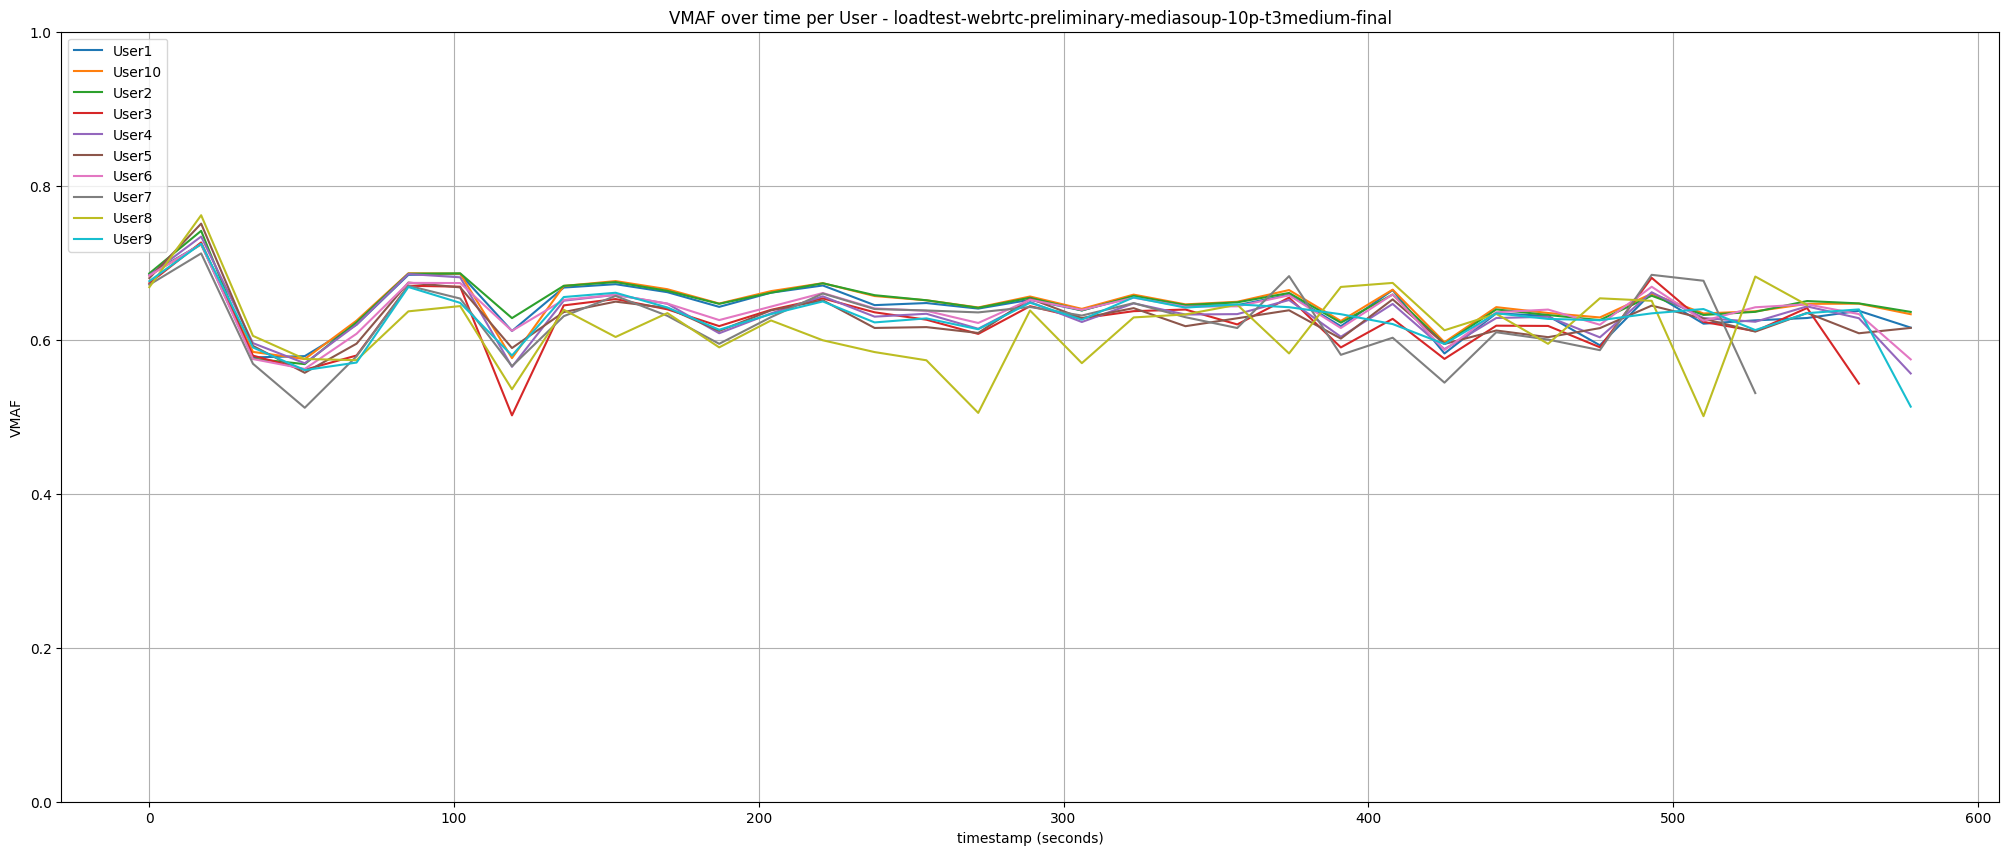

In [40]:
plt.rcParams['figure.figsize'] = [25, 10]

df_user = df_list[index]

for user in df_user.userFrom.unique():
    df_user1 = df_user[df_user.userFrom == user].groupby(["cut_index"]).mean(numeric_only=True)
    plt.plot(df_user1.index, df_user1[metric], label=user)

plt.title(metric_label + " over time per User - " + index_name)
plt.xlabel("timestamp (seconds)")
plt.ylabel(metric_label)
plt.legend(loc="upper left")
plt.grid()
if show_full_range:
    plt.ylim(0, 1)


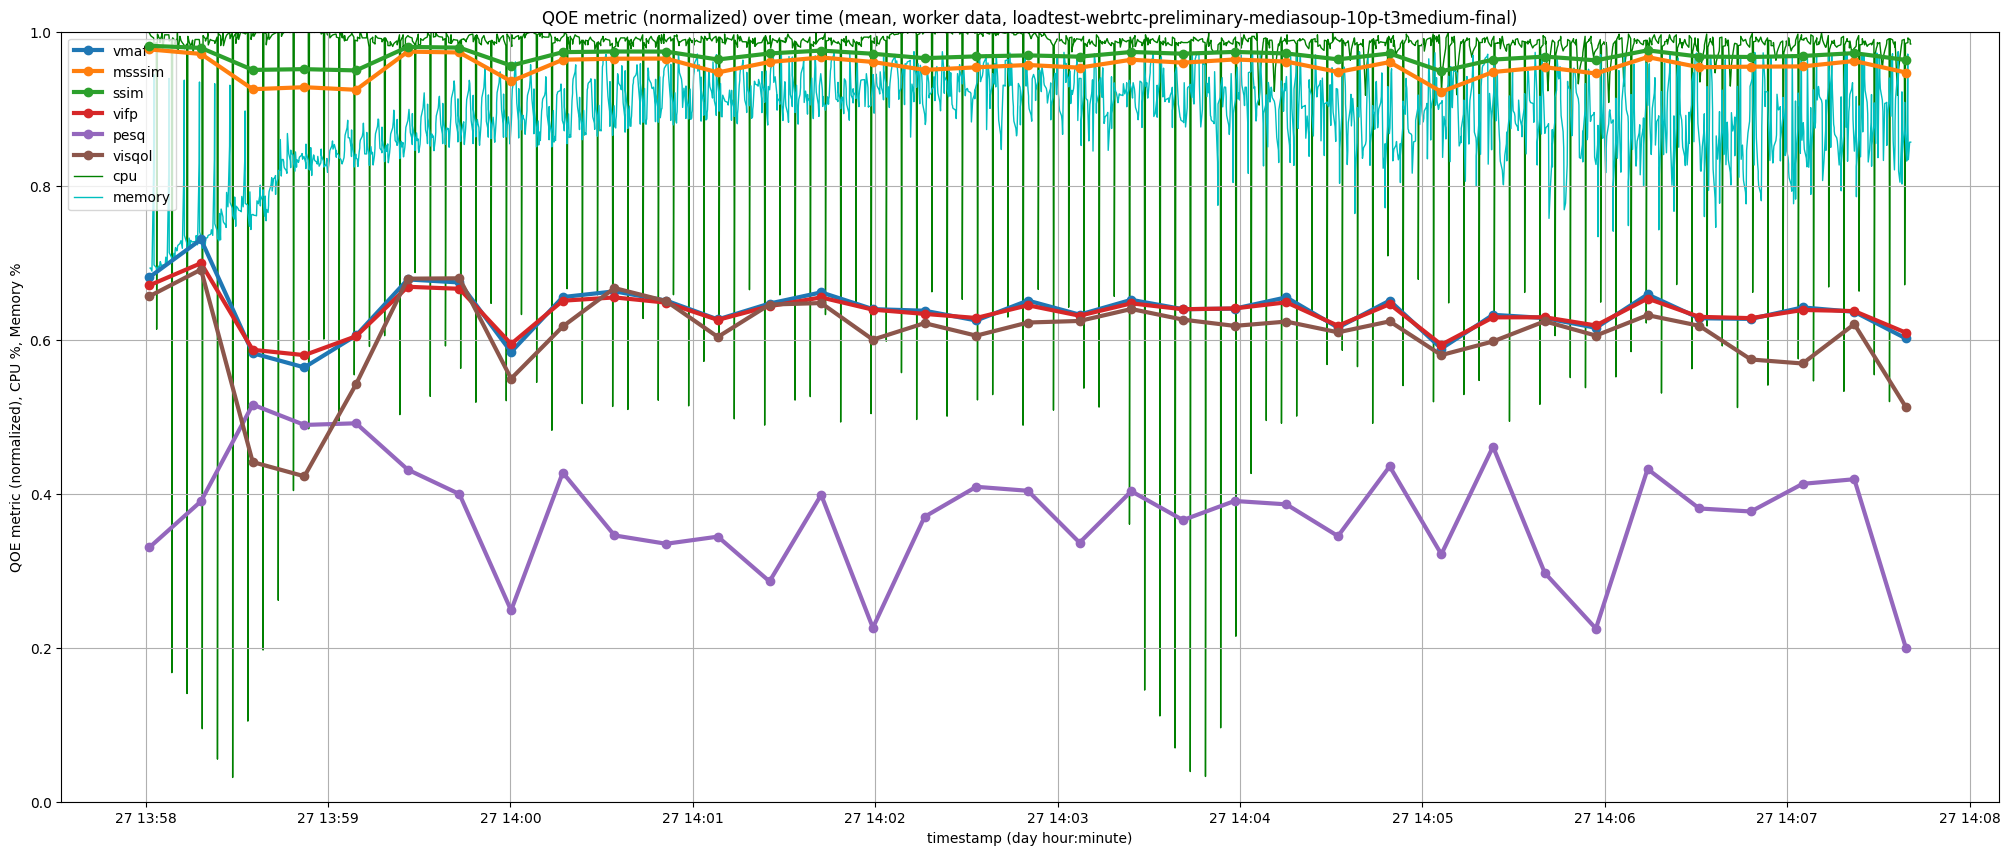

In [41]:
plt.rcParams['figure.figsize'] = [25, 10]

aggregation_map =  {"@timestamp": "first"}
for metric in qoe_metrics_normalized:
    aggregation_map[metric] = "mean"

df_tmp = df_list[index].groupby("cut_index").agg(aggregation_map)
df_node = pd.read_csv(f"dfs/{index_name}-browseremulator.csv")
df_node["@timestamp"] = pd.to_datetime(df_node["@timestamp"])
df = pd.concat([df_tmp, df_node])

qoe_zorder = 10
resource_zorder = 0

qoe_linewidth = 3
resource_linewidth = 1

for metric in qoe_metrics_normalized:
    plt.plot(df["@timestamp"], df[metric], label=metric,
             marker="o", zorder=qoe_zorder, lw=qoe_linewidth)
plt.plot(df["@timestamp"], df["cpu"].interpolate(method="linear"), "g",
         label="cpu", zorder=resource_zorder, lw=resource_linewidth)
plt.plot(df["@timestamp"], df["memory"].interpolate(method="linear"), "c",
         label="memory", zorder=resource_zorder, lw=resource_linewidth)

plt.title(f"QOE metric (normalized) over time (mean, worker data, {index_name})")
plt.xlabel("timestamp (day hour:minute)")
plt.ylabel("QOE metric (normalized), CPU %, Memory %")
plt.grid()
if show_full_range:
    plt.ylim(0, 1)
plt.legend(loc="upper left")


In [42]:

from scipy.stats import friedmanchisquare, wilcoxon, kruskal

vmaf_series_t3 = []
vmaf_series_c5 = []

for i, df_tmp in enumerate(df_list):
    df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
    if (i % 2 == 0):
        vmaf_series_t3.append(df_mean["vmaf"][:34])
    else:
        vmaf_series_c5.append(df_mean["vmaf"][:34])

print("Friedman Kruskal tests with all t3.medium data:")
print(friedmanchisquare(*vmaf_series_t3))
print(kruskal(*vmaf_series_t3))
print()
print("Friedman Kruskal tests with all c5.xlarge data:")
print(friedmanchisquare(*vmaf_series_c5))
print(kruskal(*vmaf_series_c5))
print()
print("Wilcoxon Friedman Kruskal tests between 2p and 10p for t3.medium")
print(wilcoxon(vmaf_series_t3[0], vmaf_series_t3[-1]))
print(friedmanchisquare(vmaf_series_c5[0], vmaf_series_c5[-1], vmaf_series_t3[-2]))
print(kruskal(vmaf_series_c5[0], vmaf_series_c5[-1]))
print()
print("Wilcoxon Friedman Kruskal tests between 2p and 10p for c5.xlarge")
print(wilcoxon(vmaf_series_c5[0], vmaf_series_c5[-1]))
print(friedmanchisquare(vmaf_series_c5[0], vmaf_series_c5[-1], vmaf_series_c5[-2]))
print(kruskal(vmaf_series_c5[0], vmaf_series_c5[-1]))

Friedman Kruskal tests with all t3.medium data:
FriedmanchisquareResult(statistic=215.98039215686276, pvalue=4.703432042230085e-43)
KruskalResult(statistic=240.3844918057721, pvalue=3.078486849298089e-48)

Friedman Kruskal tests with all c5.xlarge data:
FriedmanchisquareResult(statistic=119.47058823529414, pvalue=9.875064114951029e-23)
KruskalResult(statistic=124.21104414616514, pvalue=1.0155753978758864e-23)

Wilcoxon Friedman Kruskal tests between 2p and 10p for t3.medium
WilcoxonResult(statistic=248.0, pvalue=0.3973979573878428)
FriedmanchisquareResult(statistic=0.4117647058823195, pvalue=0.8139288269830159)
KruskalResult(statistic=0.012185948548221859, pvalue=0.9121000962619648)

Wilcoxon Friedman Kruskal tests between 2p and 10p for c5.xlarge
WilcoxonResult(statistic=253.0, pvalue=0.4467795673267191)
FriedmanchisquareResult(statistic=1.117647058823536, pvalue=0.57188146996762)
KruskalResult(statistic=0.012185948548221859, pvalue=0.9121000962619648)
